In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

# CUSTOM **DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/newData.csv', encoding='windows-1252')

In [ ]:
df.head(3)

,text,label
0,My dezire kl 07 cm 8766 Jijo pp My new vehicle...,issue not resolved
1,I bought a new gixxer sf 150cc (Black) on june...,other
2,Because i heard you deliver the bikes with bes...,other


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.class_encode_column("label")

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 583
})

In [ ]:
dataset['label']

In [ ]:
# Load custom data
'''
dataset = load_dataset("csv", data_files={"train": "/content/call_recoding_data.csv", "test": "/content/call_recoding_data.csv"})
from datasets import ClassLabel
dataset = load_dataset('csv', data_files={"train": "/content/call_recoding_data.csv", "test": "/content/call_recoding_data.csv"}, names=["text", "label"]) # names=["text", "label"]
# dataset.cast_column("label", ClassLabel(names = ['New customer Lead not booked', 'Missed Call', 'Existing Customer - Lead closed', 'Other', 'Voicemail Lead', 'Out of Service Capabilities', 'Existing Customer - Lead not closed', 'New customer Lead booked'] ))

train_ds, test_ds = dataset['train'], dataset['test']
train_ds
train_ds.features['label']
'''

In [ ]:
train_ds, test_ds = dataset, dataset

In [ ]:
labels = train_ds.features['label'].names
print(labels)

['defective part of vehicle', 'issue not resolved', 'manufacture defective', 'multiple issue', 'other', 'service center issue']


In [ ]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
print(id2label)

{0: 'defective part of vehicle', 1: 'issue not resolved', 2: 'manufacture defective', 3: 'multiple issue', 4: 'other', 5: 'service center issue'}


Next, we prepare the data for the model using the tokenizer.

In [ ]:
from transformers import PerceiverTokenizer

tokenizer = PerceiverTokenizer.from_pretrained("deepmind/language-perceiver")

train_ds = train_ds.map(lambda examples: tokenizer(examples['text'], padding="max_length"), #
                        batched=True)
test_ds = test_ds.map(lambda examples: tokenizer(examples['text'], padding="max_length"), # , truncation=True
                      batched=True)

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

We set the format to PyTorch tensors, and create familiar PyTorch dataloaders.

In [ ]:
train_ds.set_format(type="torch", columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type="torch", columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=4)

Here we verify some things (always important to check out your data!).

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

label torch.Size([4])
input_ids torch.Size([4, 2048])
attention_mask torch.Size([4, 2048])


In [ ]:
tokenizer.decode(batch['input_ids'][3])

'[CLS]The main issue is dealer has fixed a wrong model of gear lock in my car, because of this the driver side seat is not sliding properly and neither competent showroom nor maruti team are ready to fix it.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA

In [ ]:
batch['label']

tensor([5, 5, 2, 2])

## Define model

Next, we define our model, and put it on the GPU.

In [ ]:
from transformers import PerceiverForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PerceiverForSequenceClassification.from_pretrained("deepmind/language-perceiver",
                                                               num_labels=6,
                                                               id2label=id2label,
                                                               label2id=label2id)
model.to(device)

In [ ]:
# model.save_pretrained('/content/drive/MyDrive/kishor')  # it is used to save the model

## It is used to upload the model after the model is saved

In [ ]:
tokenizer = PerceiverTokenizer.from_pretrained("deepmind/language-perceiver")

model = PerceiverForSequenceClassification.from_pretrained("/content/drive/MyDrive/kishor")
model.to(device)


## Train the model

Here we train the model using native PyTorch.

In [ ]:
# from transformers import AdamW
# from tqdm.notebook import tqdm
# from sklearn.metrics import accuracy_score

# optimizer = AdamW(model.parameters(), lr=1e-7)

# model.train()
# for epoch in range(100):  # loop over the dataset multiple times
#     print("Epoch:", epoch)
#     for batch in tqdm(train_dataloader):
#          # get the inputs;
#          inputs = batch["input_ids"].to(device)
#          attention_mask = batch["attention_mask"].to(device)
#          labels = batch["label"].to(device)

#          # zero the parameter gradients
#          optimizer.zero_grad()

#          # forward + backward + optimize
#          outputs = model(inputs=inputs, attention_mask=attention_mask, labels=labels)
#          loss = outputs.loss
#          loss.backward()
#          optimizer.step()

#          # evaluate
#          predictions = outputs.logits.argmax(-1).cpu().detach().numpy()
#          accuracy = accuracy_score(y_true=batch["label"].numpy(), y_pred=predictions)
#          print(f"Loss: {loss.item()}, Accuracy: {accuracy}")

## Evaluate the model

Finally, we evaluate the model on the test set. We use the Datasets library to compute the accuracy.

In [ ]:
# from tqdm.notebook import tqdm
# from datasets import load_metric

# accuracy = load_metric("accuracy")

# model.eval()
# for batch in tqdm(test_dataloader):
#       # get the inputs;
#       inputs = batch["input_ids"].to(device)
#       attention_mask = batch["attention_mask"].to(device)
#       labels = batch["label"].to(device)

#       # forward pass
#       outputs = model(inputs=inputs, attention_mask=attention_mask)
#       logits = outputs.logits
#       predictions = logits.argmax(-1).cpu().detach().numpy()
#       references = batch["label"].numpy()
#       accuracy.add_batch(predictions=predictions, references=references)

# final_score = accuracy.compute()
# print("Accuracy on test set:", final_score)

## Inference

In [ ]:
# model.save_pretrained('/content/drive/MyDrive/kishor')

In [ ]:
import torch

print(torch.cuda.is_available())

True


## it is to check the inference of the model


In [ ]:
import torch
import time

class Inference:
    def __init__(self, model_path):
        self.model_path = model_path
        if torch.cuda.is_available():
            self.device = 'cuda:0'
        else:
            self.device = 'cpu'
        print(f"Inferencing on {self.device}")
        self.tokenizer = PerceiverTokenizer.from_pretrained("deepmind/language-perceiver")
        self.model = PerceiverForSequenceClassification.from_pretrained(self.model_path)
        self.model.to(self.device)
        # self.model.cuda()
        self.model.eval()
        print("Model Loaded!!")

    def run(self, input_text):
        input_ids = self.tokenizer(text, return_tensors="pt").input_ids
        outputs = self.model(inputs=input_ids.to(self.device))
        logits = outputs.logits
        predictions = logits.argmax(-1).item()
        output = self.model.config.id2label[predictions]


        return output


if __name__ == "__main__":
    infer = Inference('/content/drive/MyDrive/kishor')

    text_input = ["I call service center many times but he not come for looking what happened and not pickup call",
                  "14 lakh rupees 2 month before to purchase one the best product of maruti suzuki india and one of the best sedan car of maruti suzuki india",
                  "Maruti suzuki should be directly responsible for the defects and problems in the engine silencer and meter board",
                  "9th august rear tyre condition On next two days on 12th august goodyear engineer came he inspect the tyre (As per nexa team) and reject the claim and said that tyre was run on low air pressure",
                  "Maruti suzuki should be directly responsible for the defects and problems in the engine silencer and meter board",
                  "But till date the music system is not repaired and they asked me further 2 days after giving 10 days from delivery of the car",
                  "Even i did not get any proper response from center also",
                  "When we raise the complaint for the new car vehicle0",
                  "ItÂ’s time to moral responsibility to raise the complaint by maruti india and take it seriously  He told me that it is the process that customer has to raise the complaints",
                  "Still i have not getting the service report from good year tyre which inspection was don on 27th august."]

    # df1 = pd.read_csv("/content/maruti (1).csv")
    # for line in df1[' complaint_text']:
    #   text_input = []
    #   text_input = line.split(".")
    with open('output.csv', "w") as tt:
      for text in text_input:
        t1 = time.time()
        print("INPUT text: ", text)
        output = infer.run(text)
        t2 = time.time()
        print("OUTPUT: ", output)
        tt.write(text + '\t' + output + '\n')
        print(f'Inference time: {round((t2-t1), 3)}s')

Inferencing on cuda:0


Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


Model Loaded!!
INPUT text:  I call service center many times but he not come for looking what happened and not pickup call
OUTPUT:  service center issue
Inference time: 2.628s
INPUT text:  14 lakh rupees 2 month before to purchase one the best product of maruti suzuki india and one of the best sedan car of maruti suzuki india
OUTPUT:  other
Inference time: 0.057s
INPUT text:  Maruti suzuki should be directly responsible for the defects and problems in the engine silencer and meter board
OUTPUT:  manufacture defective
Inference time: 0.056s
INPUT text:  9th august rear tyre condition On next two days on 12th august goodyear engineer came he inspect the tyre (As per nexa team) and reject the claim and said that tyre was run on low air pressure
OUTPUT:  defective part of vehicle
Inference time: 0.037s
INPUT text:  Maruti suzuki should be directly responsible for the defects and problems in the engine silencer and meter board
OUTPUT:  manufacture defective
Inference time: 0.034s
INPUT text

In [ ]:
df1 = pd.read_csv("/content/output.csv")

In [ ]:
# Column names to be added
column_names=["infer"]

# # Create DataFrame by assigning column names
# df=pd.DataFrame(technologies, columns=column_names)

# Add column names while reading a CSV file
df1 = pd.read_csv('/content/output.csv', names=column_names)

In [ ]:
df1.head()

,infer
0,I call service center many times but he not co...
1,14 lakh rupees 2 month before to purchase one ...
2,Maruti suzuki should be directly responsible f...
3,9th august rear tyre condition On next two day...
4,Maruti suzuki should be directly responsible f...


In [ ]:
df1['infer_text'] = df1.infer.str.split('\t', expand = True)[0]
df1['infer_label'] = df1.infer.str.split('\t', expand = True)[1]

In [ ]:
df1

,infer,infer_text,infer_label
0,I call service center many times but he not co...,I call service center many times but he not co...,service center issue
1,14 lakh rupees 2 month before to purchase one ...,14 lakh rupees 2 month before to purchase one ...,other
2,Maruti suzuki should be directly responsible f...,Maruti suzuki should be directly responsible f...,manufacture defective
3,9th august rear tyre condition On next two day...,9th august rear tyre condition On next two day...,defective part of vehicle
4,Maruti suzuki should be directly responsible f...,Maruti suzuki should be directly responsible f...,manufacture defective
5,But till date the music system is not repaired...,But till date the music system is not repaired...,service center issue
6,Even i did not get any proper response from ce...,Even i did not get any proper response from ce...,service center issue
7,When we raise the complaint for the new car ve...,When we raise the complaint for the new car ve...,manufacture defective
8,ItÂ’s time to moral responsibility to raise th...,ItÂ’s time to moral responsibility to raise th...,other
9,Still i have not getting the service report fr...,Still i have not getting the service report fr...,other


# visualization before the training the data


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df.head(2)

,text,label
0,My dezire kl 07 cm 8766 Jijo pp My new vehicle...,issue not resolved
1,I bought a new gixxer sf 150cc (Black) on june...,other


In [ ]:
df['label'].value_counts().sum()

583

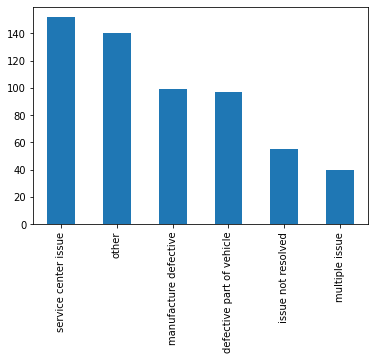

In [ ]:
plt.figure()
df.label.value_counts().plot(kind = 'bar')

## visualization for the inference data

In [ ]:
df1["infer_label"].value_counts()

service center issue         3
other                        3
manufacture defective        3
defective part of vehicle    1
Name: infer_label, dtype: int64

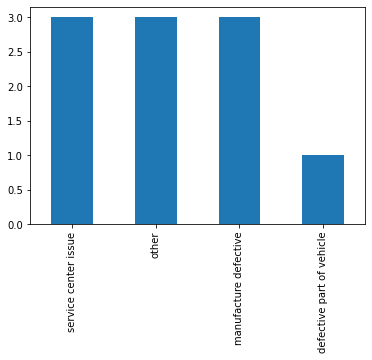

In [ ]:
plt.figure()
df1.infer_label.value_counts().plot(kind = 'bar')

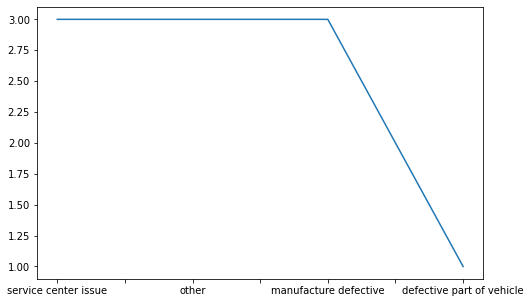

In [ ]:
plt.figure(figsize=(8,5))
df1.infer_label.value_counts().plot(kind = 'line')